# Parte 2: Preparação e Análise dos Dados


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pygal as pg

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
import xgboost as xgb

def pgr(chart_object, nome_arquivo):
    """
    Função para renderizar arquivos SVG criados por pygal em um jupyter notebook, 
    ela cria uma pasta charts na pasta de trabalho salva o SVG nela e sem seguida,
    renderiza o SVG em um HTML usando a tag <object>, que é a tag apropriada para SVG dinâmico. 
    
    args: 
        - chart_object (um objeto de gráfico em pygal que queremos renderizar)
        - nome_arquivo (o nome)
    return:
        - SVG dinâmico renderizado em HTML.
    
    """
    import os
    from IPython.display import HTML
    os.makedirs('charts', exist_ok=True) 
    
    chart_object.render_to_file(f"charts/{nome_arquivo}.svg")
    
    return HTML(''' <object data="charts/{}.svg" width=95% height=80%> </object> '''.format(nome_arquivo))

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Preparação dos dados

Vamos carregar o arquivo com fenótipos e o arquivo com as snps para depois juntá-los

In [2]:
# load data
phenotypes = pd.read_csv('datasets/eye_color_df_snp.csv')
phenotypes_filenames = pd.read_csv('datasets/true_filenames.csv')
snps = pd.read_csv('datasets/users_snps.csv')

In [3]:
print("Relembrando como são os dados:")
print("")
print("Dataset com fenótipos:")
print(f"Tamanho: {len(phenotypes)}")
display(phenotypes.head(2))
print("Dataset com snps:")
print(f"Tamanho: {len(snps)}")
display(snps.head(2))



Relembrando como são os dados:

Dataset com fenótipos:
Tamanho: 1286


,user_id,genotype_filename,Eye color,color_cat
0,2953,2953.ftdna-illumina.1885,Dark brown,Brown
1,4135,4135.ftdna-illumina.2801,Blue-grey,BGG


Dataset com snps:
Tamanho: 1264


,rs12913832,rs1800407,rs12896399,rs16891982,rs1393350,rs12203592,rs1129038,rs116363232,rs1289399,user_id
0,missing,CC,missing,missing,missing,missing,TC,missing,missing,2953
1,missing,TC,missing,missing,missing,missing,TT,missing,missing,4135


Juntando os dados

In [4]:
df = pd.merge(left = snps, right = phenotypes, how = 'left', on = 'user_id')
print(f"Tamanho: {len(df)}")
display(df.head(2))

Tamanho: 1264


,rs12913832,rs1800407,rs12896399,rs16891982,rs1393350,rs12203592,rs1129038,rs116363232,rs1289399,user_id,genotype_filename,Eye color,color_cat
0,missing,CC,missing,missing,missing,missing,TC,missing,missing,2953,2953.ftdna-illumina.1885,Dark brown,Brown
1,missing,TC,missing,missing,missing,missing,TT,missing,missing,4135,4135.ftdna-illumina.2801,Blue-grey,BGG


In [5]:
# Conjunto com as SNPs
snp_list = ['rs12913832', 'rs1800407', 'rs12896399', 'rs16891982', 'rs1393350',
        'rs12203592', 'rs1129038', 'rs116363232', 'rs1289399']

In [6]:
for snp in snp_list:
    print(df[snp].value_counts())
    print("*"*30)

GG         566
AG         381
AA         167
missing    148
BB           1
Name: rs12913832, dtype: int64
******************************
CC         1044
CT          113
missing      59
TC           37
TT            8
BB            1
GG            1
Name: rs1800407, dtype: int64
******************************
GT         432
GG         344
missing    230
TT         197
TG          57
AA           1
AB           1
AC           1
Name: rs12896399, dtype: int64
******************************
GG         757
missing    324
CG         124
CC          45
GC           9
AB           1
Name: rs16891982, dtype: int64
******************************
GG         635
AG         401
missing    148
AA          73
GA           5
BB           1
Name: rs1393350, dtype: int64
******************************
CC         794
CT         221
missing    149
TC          59
TT          38
BB           1
GG           1
Name: rs12203592, dtype: int64
******************************
TT         595
CT         298
CC      

Vamos tratar estas colunas uma por uma.

Descartando entradas que tiverem fora do padrão e transformando dois alelos diferentes em apenas um coisa só. 
("TC" e "CT", por exemplo, têm o mesmo significado).

**Primeira Coluna:**

In [7]:
col0 = snp_list[0] 
print(f"Snp analisada: {col0}")
display(df[col0].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs12913832


GG         566
AG         381
AA         167
missing    148
BB           1
Name: rs12913832, dtype: int64

Tamanho df inicial: 1264


In [8]:
to_remove = "BB"
print(f"Entradas fora do padrão: {to_remove}")
print("Removendo entradas fora do padrão")
df = df[df[col0] != to_remove]
print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: BB
Removendo entradas fora do padrão
Tamanho df final: 1263


**Segunda Coluna:**

In [9]:
col1 = snp_list[1] 
print(f"Snp analisada: {col1}")
display(df[col1].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1800407


CC         1044
CT          113
missing      59
TC           37
TT            8
GG            1
Name: rs1800407, dtype: int64

Tamanho df inicial: 1263


In [10]:
to_remove = "GG"
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col1] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col1] = df[col1].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: GG
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1262


**Terceira Coluna:**

In [11]:
col2 = snp_list[2] 
print(f"Snp analisada: {col2}")
display(df[col2].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs12896399


GT         432
GG         344
missing    230
TT         197
TG          57
AA           1
Name: rs12896399, dtype: int64

Tamanho df inicial: 1262


In [12]:
to_remove = "AA"
iguais = ["GT", "TG"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col2] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col2] = df[col2].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: AA
Entradas iguais: ['GT', 'TG']
Removendo entradas fora do padrão...
Substituindo TG por GT...
Tamanho df final: 1261


**Quarta Coluna:**

In [13]:
col3 = snp_list[3] 
print(f"Snp analisada: {col3}")
display(df[col3].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs16891982


GG         757
missing    323
CG         124
CC          44
GC           9
Name: rs16891982, dtype: int64

Tamanho df inicial: 1261


In [14]:
to_remove = ""
iguais = ["CG", "GC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col3] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col3] = df[col3].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CG', 'GC']
Removendo entradas fora do padrão...
Substituindo GC por CG...
Tamanho df final: 1261


**Quinta Coluna:**

In [15]:
col4 = snp_list[4] 
print(f"Snp analisada: {col4}")
display(df[col4].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1393350


GG         634
AG         401
missing    147
AA          73
GA           5
Name: rs1393350, dtype: int64

Tamanho df inicial: 1261


In [16]:
to_remove = ""
iguais = ["AG", "GA"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col4] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col4] = df[col4].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['AG', 'GA']
Removendo entradas fora do padrão...
Substituindo GA por AG...
Tamanho df final: 1261


**Sexta Coluna**

In [17]:
col5 = snp_list[5]
print(f"Snp analisada: {col5}")
display(df[col5].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs12203592


CC         794
CT         221
missing    148
TC          59
TT          38
Name: rs12203592, dtype: int64

Tamanho df inicial: 1261


In [18]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col5] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col5] = df[col5].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1261


**Sétima Coluna**

In [19]:
col6 = snp_list[6]
print(f"Snp analisada: {col6}")
display(df[col6].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1129038


TT         595
CT         298
CC         183
TC         105
missing     78
Name: rs1129038, dtype: int64

Tamanho df inicial: 1261


In [20]:
to_remove = ""
iguais = ["CT", "TC"]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col6] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col6] = df[col6].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: ['CT', 'TC']
Removendo entradas fora do padrão...
Substituindo TC por CT...
Tamanho df final: 1261


**Oitava Coluna**

In [21]:
col7 = snp_list[7]
print(f"Snp analisada: {col7}")
display(df[col7].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs116363232


missing    1090
CC          167
CT            3
Name: rs116363232, dtype: int64

Tamanho df inicial: 1261


In [22]:
to_remove = ""
iguais = [" ", " "]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col7] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col6] = df[col7].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: [' ', ' ']
Removendo entradas fora do padrão...
Substituindo   por  ...
Tamanho df final: 1261


**Nona Coluna**

In [23]:
col8 = snp_list[8]
print(f"Snp analisada: {col8}")
display(df[col8].value_counts())
print(f"Tamanho df inicial: {len(df)}")

Snp analisada: rs1289399


CC         460
missing    429
CT           3
Name: rs1289399, dtype: int64

Tamanho df inicial: 1261


In [24]:
to_remove = ""
iguais = [" ", " "]

print(f"Entradas fora do padrão: {to_remove}")
print(f"Entradas iguais: {iguais}")
print("Removendo entradas fora do padrão...")

df = df[df[col8] != to_remove]

print(f"Substituindo {iguais[1]} por {iguais[0]}...")
df[col6] = df[col8].replace(iguais[0], iguais[1])

print(f"Tamanho df final: {len(df)}")

Entradas fora do padrão: 
Entradas iguais: [' ', ' ']
Removendo entradas fora do padrão...
Substituindo   por  ...
Tamanho df final: 1261


**Parece que algumas entradas ainda têm valores nulos... Vamos trocar por "missing"**

In [25]:
df.isna().sum()

rs12913832             1
rs1800407              1
rs12896399             1
rs16891982             4
rs1393350              1
rs12203592             1
rs1129038            369
rs116363232            1
rs1289399            369
user_id                0
genotype_filename      0
Eye color              0
color_cat              0
dtype: int64

In [26]:
df = df.fillna("missing")
df.isna().sum()

rs12913832           0
rs1800407            0
rs12896399           0
rs16891982           0
rs1393350            0
rs12203592           0
rs1129038            0
rs116363232          0
rs1289399            0
user_id              0
genotype_filename    0
Eye color            0
color_cat            0
dtype: int64

**Vamos analisar a proporção de valores faltantes nos nossos atributos**

In [27]:
snp_dict = {}
for col in snp_list:
    qmissing = round((df[col] == 'missing').sum()/len(df), 2)
    qnotmissing = round((1 - qmissing), 2)
    print(f"{col}: Quantidade missing = {qmissing}, Quantidade não missing = {qnotmissing}")

rs12913832: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs1800407: Quantidade missing = 0.05, Quantidade não missing = 0.95
rs12896399: Quantidade missing = 0.18, Quantidade não missing = 0.82
rs16891982: Quantidade missing = 0.26, Quantidade não missing = 0.74
rs1393350: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs12203592: Quantidade missing = 0.12, Quantidade não missing = 0.88
rs1129038: Quantidade missing = 0.63, Quantidade não missing = 0.37
rs116363232: Quantidade missing = 0.87, Quantidade não missing = 0.13
rs1289399: Quantidade missing = 0.63, Quantidade não missing = 0.37


In [28]:
c = pg.Bar(print_values=True, print_values_position='top', x_label_rotation=20)
c.title = 'Dados Faltantes (em %)'
c.x_labels = snp_list
c.add('Missing', [round((df[col] == 'missing').sum()/len(df), 2) for col in snp_list])
c.add('Not Missing',  [round((1 - (df[col] == 'missing').sum()/len(df)), 2) for col in snp_list])
c.value_formatter = lambda x: f"{100*x}%"

pgr(c, "missing")

**Devido a grande proporção de valores faltantes, as últimas 3 snps não serão muito úteis, vamos removê-las**

In [29]:
df = df.drop(columns=snp_list[-3:])

In [30]:
df.head(5)

,rs12913832,rs1800407,rs12896399,rs16891982,rs1393350,rs12203592,user_id,genotype_filename,Eye color,color_cat
0,missing,CC,missing,missing,missing,missing,2953,2953.ftdna-illumina.1885,Dark brown,Brown
1,missing,TC,missing,missing,missing,missing,4135,4135.ftdna-illumina.2801,Blue-grey,BGG
2,GG,CC,GG,missing,GG,CC,4440,4440.ancestry.3043,Brown,Brown
3,GG,CC,TG,GG,GG,CC,4441,4441.23andme.3044,Blue,BGG
4,AG,CC,TG,missing,GA,CC,4111,4111.ancestry.2783,Hazel/light brown,Int


Agora sim, os dados estão prontos para uma análise estatística

# Análise Estatística

In [31]:
df = df.drop(columns = ['user_id', 'genotype_filename', 'Eye color'])
df.head(2)

,rs12913832,rs1800407,rs12896399,rs16891982,rs1393350,rs12203592,color_cat
0,missing,CC,missing,missing,missing,missing,Brown
1,missing,TC,missing,missing,missing,missing,BGG


**Para entender melhor quais valores são mutações e quais são referência segue tabela descritiva das snps.**

| SNP            | GENE             | Mutação                                           |
| -------------- | ---------------- | ------------------------------------------------- |
| **rs12913832** | **HERC2**        | Referência: AA, Presença 1: GA/AG, Presença 2: GG |
| **rs1800407**  | **OCA2**         | Referência: CC, Presença 1: CT/TC, Presença 2: TT |
| **rs12896399** | **LOC105370627** | Referência: GG, Presença 1: GT/TG, Presença 2: TT |
| **rs16891982** | **SLC45A2**      | Referência: CC, Presença 1: GC/CG, Presença 2: GG |
| **rs1393350**  | **TYR**          | Referência: GG, Presença 1: GA/AG, Presença 2: AA |
| **rs12203592** | **IRF4**         | Referência: CC, Presença 1: CT/TA, Presença 2: CC |

In [32]:
labels = list(df['color_cat'].value_counts().index)
values = list(   round(  (df['color_cat'].value_counts()) / len(df), 4) ) 

c = pg.Bar(print_values=True, print_values_position='top', x_label_rotation=20)
c.title = 'Categoria de Cor dos Olhos'
for i in range(len(labels)):
    c.add(labels[i], values[i])
c.value_formatter = lambda x: f"{100*x}%"

pgr(c, "color_count")

In [33]:
def plot_contagem(col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

    fig.suptitle(f"Análise da SNP {col} .")
    sns.countplot(ax= ax[0], x=col, data=df, palette="Blues_r")
    ax[0].set_title(f"Contagem total")
    ax[0].set_xlabel(" ")

    sns.countplot(ax= ax[1], x=col, hue="color_cat", data=df, palette="Blues_r", hue_order=["BGG", "Int", "Brown"])
    ax[1].set_title(f"Contagem Segmentada")
    plt.show()

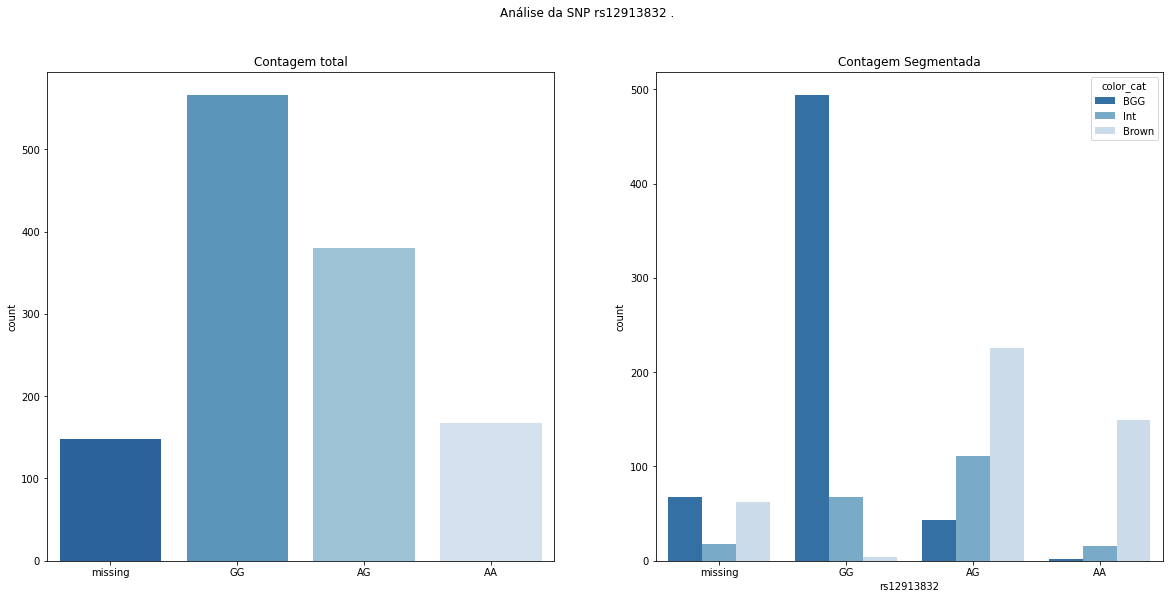

None

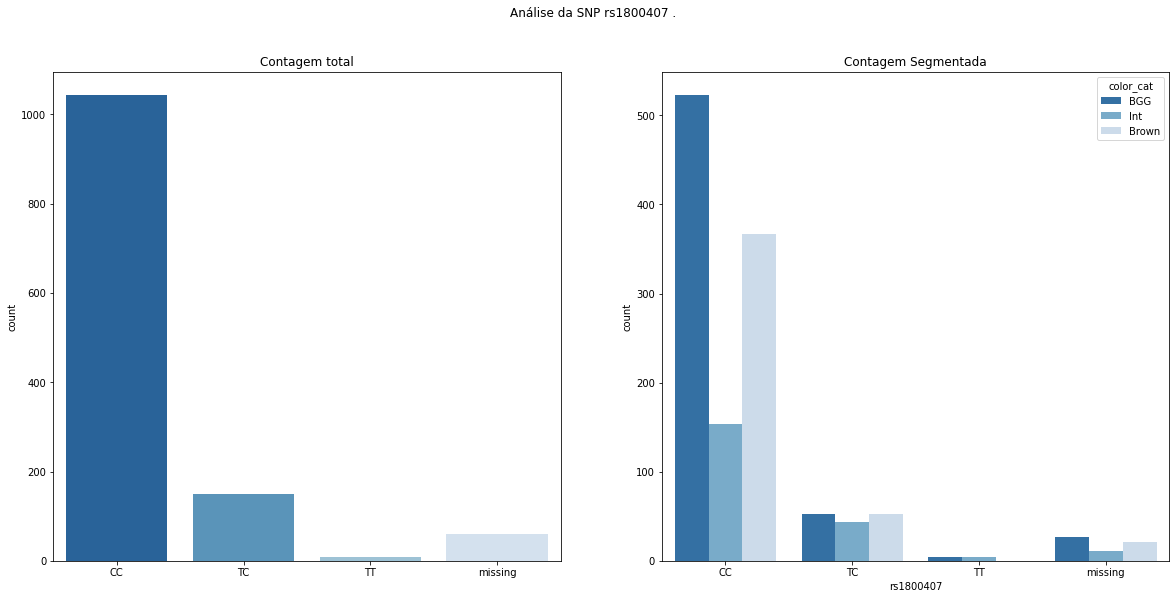

None

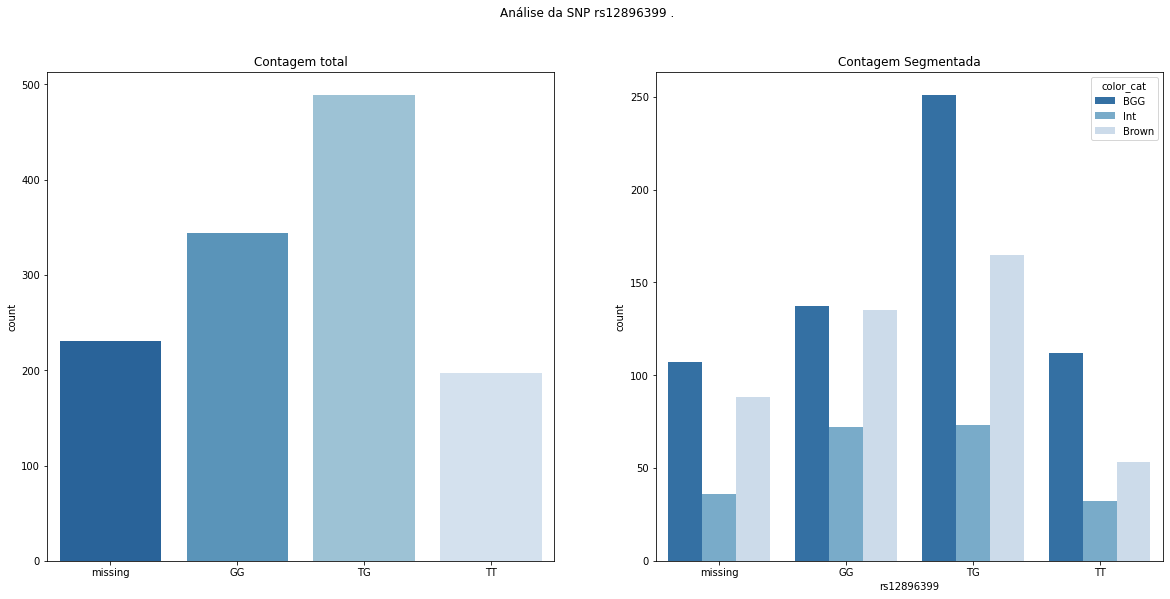

None

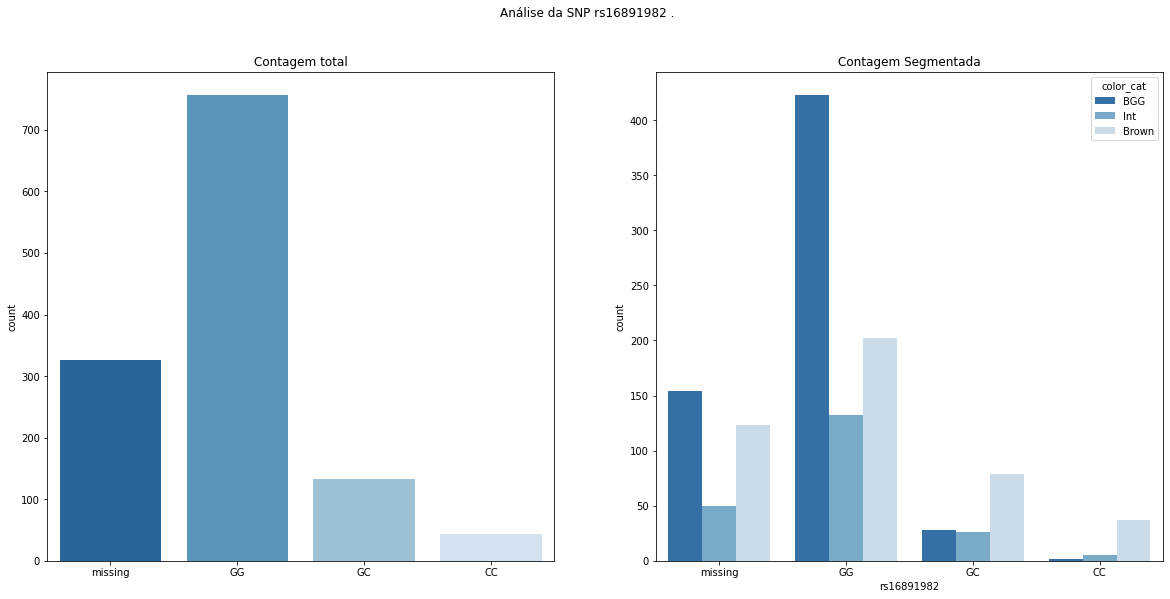

None

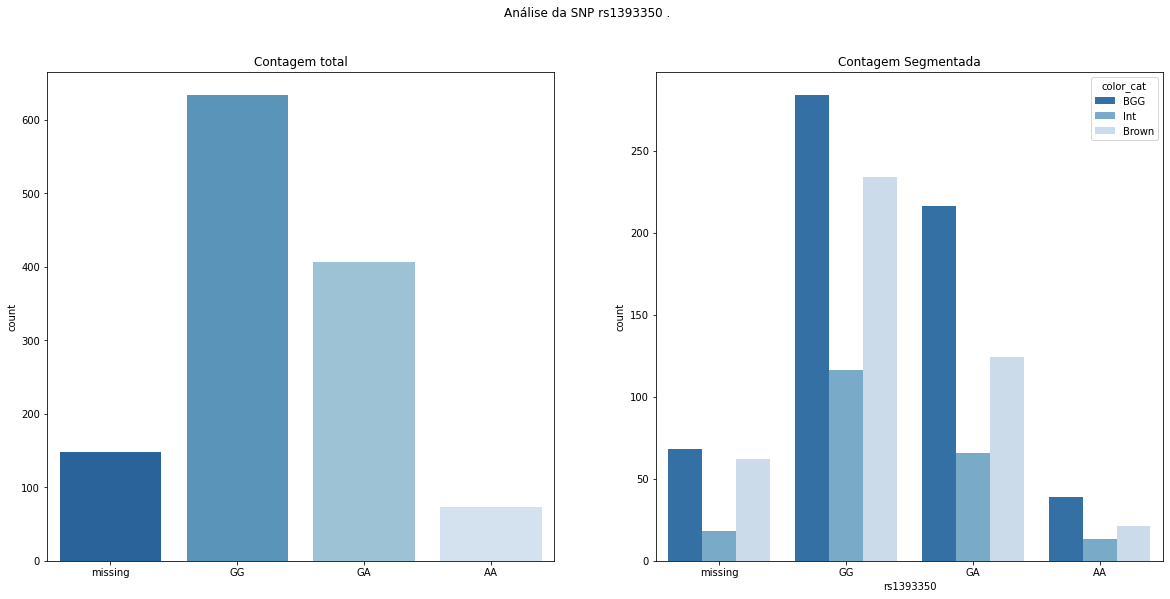

None

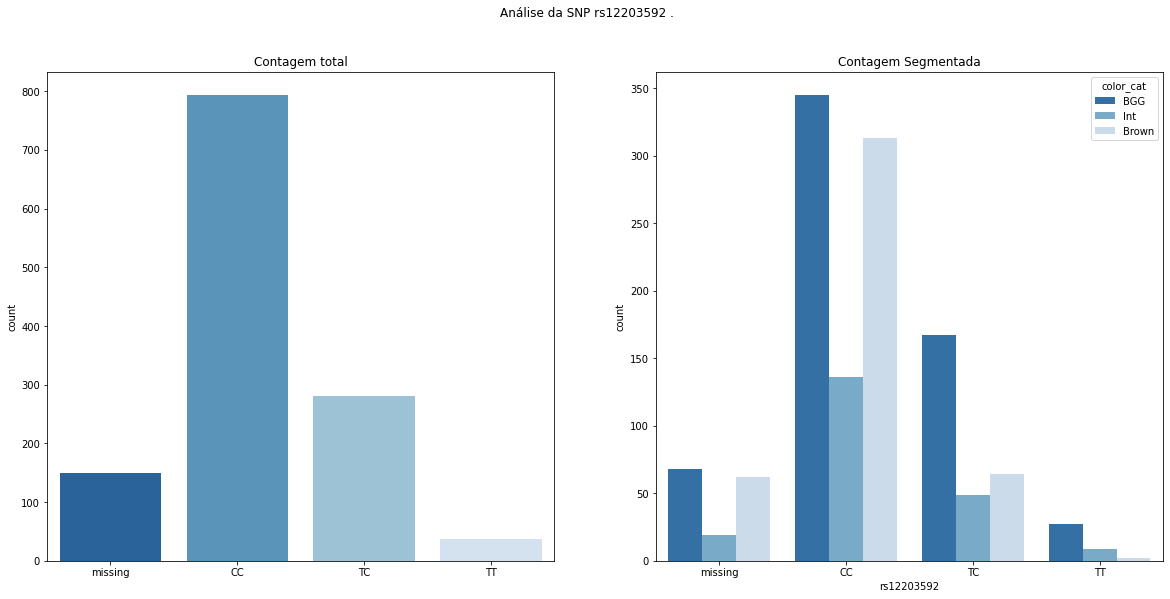

None

In [34]:
for i in df.columns[:-1]:
    display(plot_contagem(i))

snp_list[:-3]

for snp in snp_list[:-3]:
    
    df_grouped = df.groupby("color_cat")[snp].value_counts().unstack()
    df_grouped = df_grouped.apply(lambda x: round(x/x.sum(), 2) * 100)
    display(df_grouped)

## Análise da proporções das categorias para cada coluna

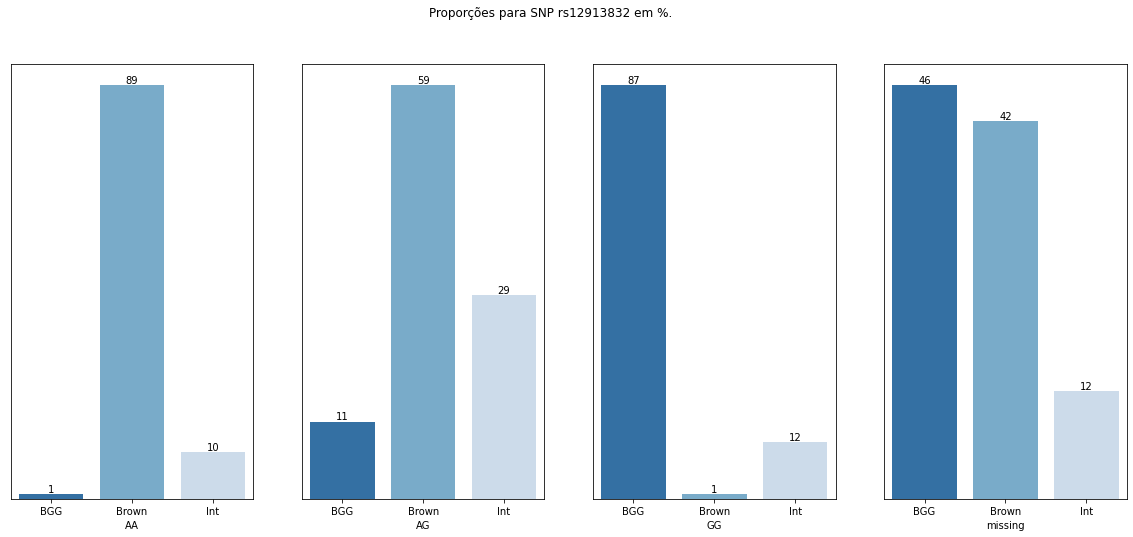

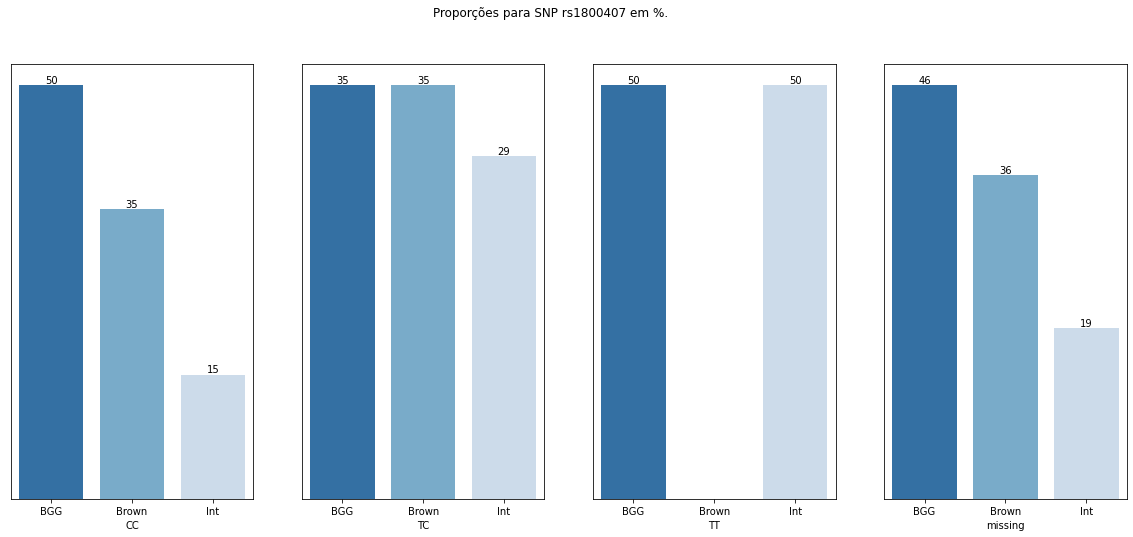

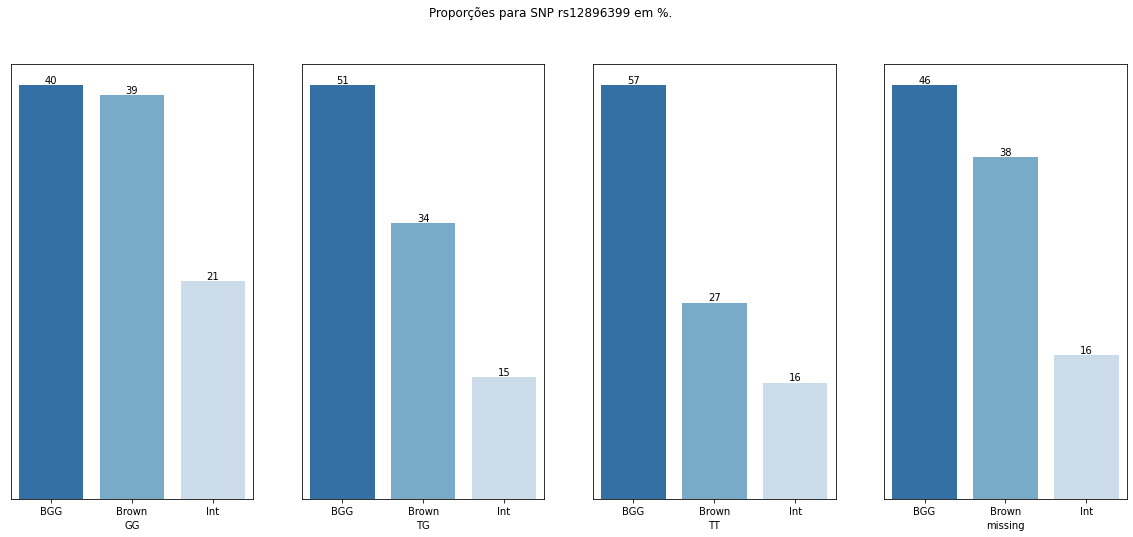

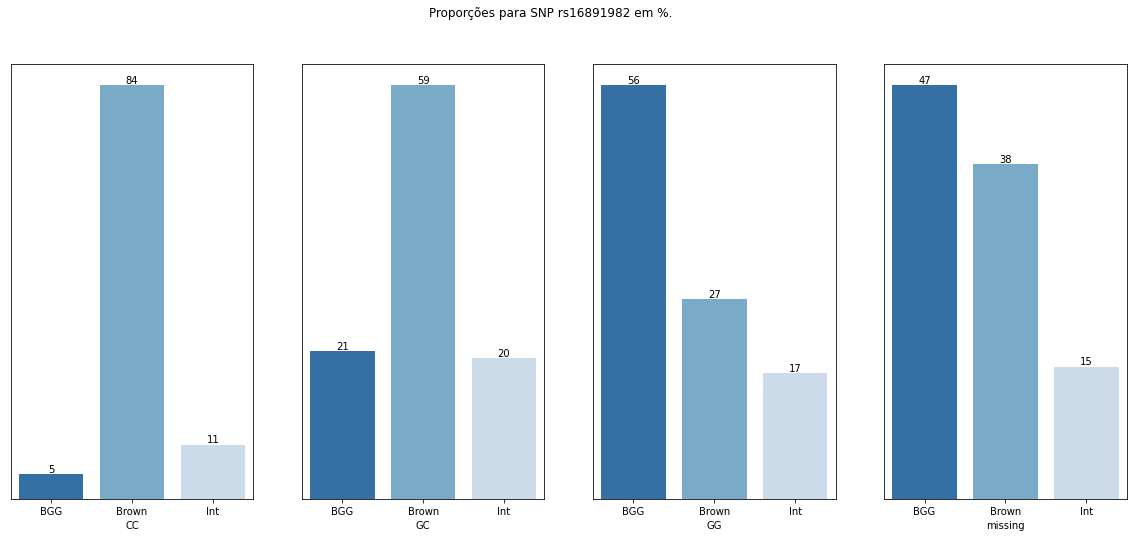

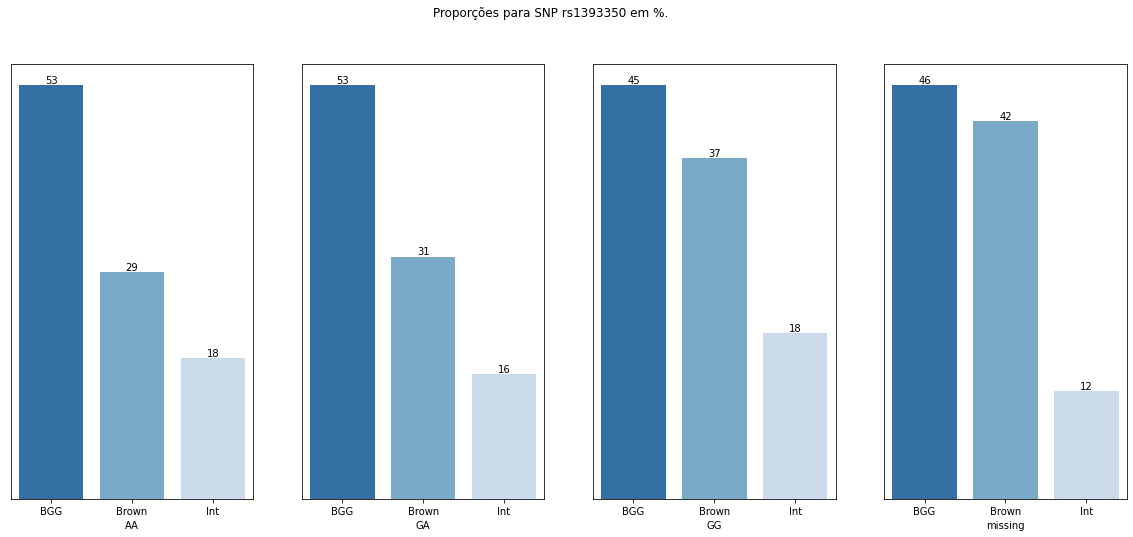

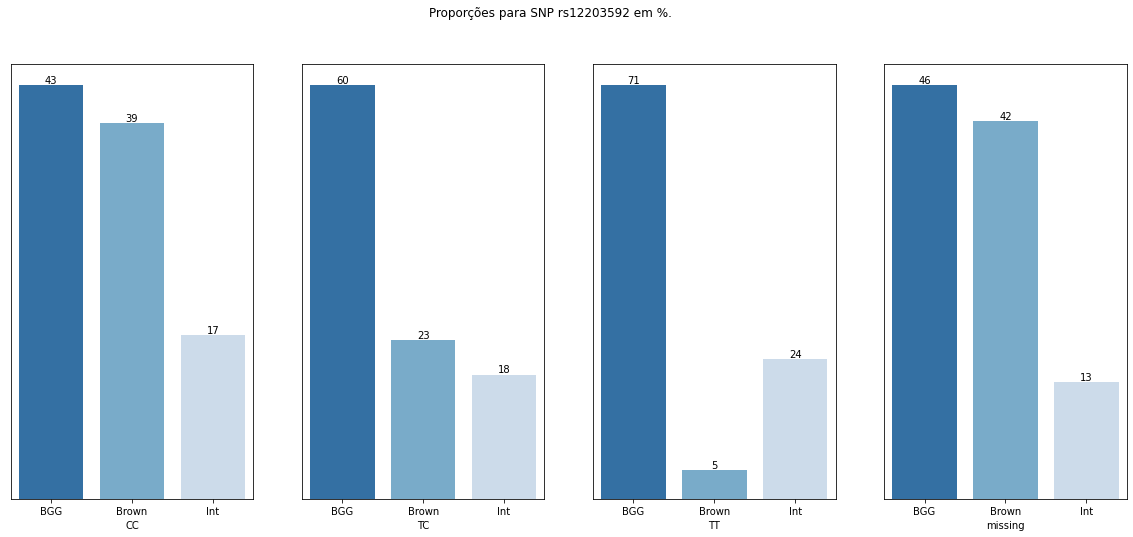

In [35]:
for snp in snp_list[:-3]:
    
    df_grouped = df.groupby("color_cat")[snp].value_counts().unstack()
    df_grouped = df_grouped.apply(lambda x: round(x/x.sum(), 2) * 100)
    df_grouped
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
    fig.suptitle(f"Proporções para SNP {snp} em %.")
    #fig.axes.get_yaxis().set_visible(False)

    for i in range(len(df_grouped.columns)):
        y = df_grouped.columns[i]
        sns.barplot(ax = ax[i], x = df_grouped.index, y=y, data = df_grouped, palette="Blues_r")
        ax[i].set_xlabel(df_grouped.columns[i])
        ax[i].set_ylabel(" ")    
        ax[i].get_yaxis().set_visible(False)
        for j in ax[i].containers:
            ax[i].bar_label(j,)

## One Hot Encoding para explorar correlações

In [36]:
df_num = pd.get_dummies(df)

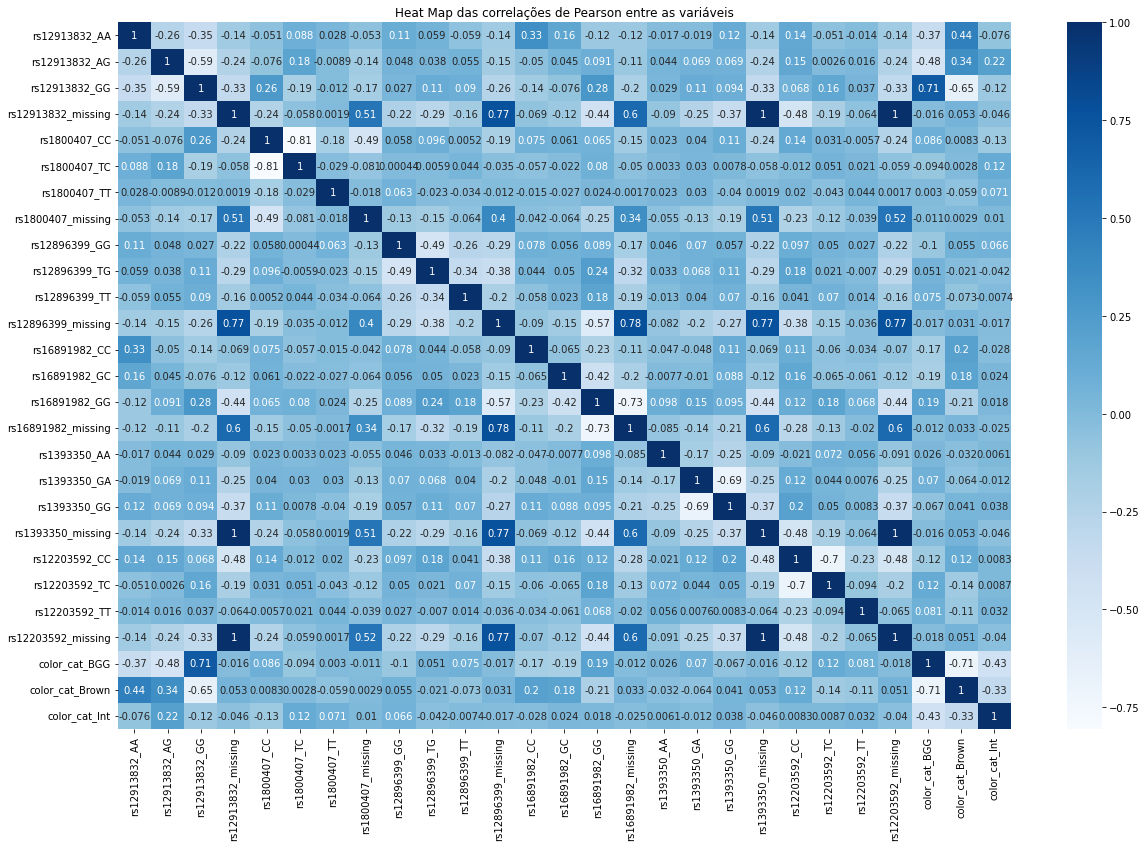

In [37]:
fig, ax = plt.subplots(figsize=(20,13))
ax = sns.heatmap(df_num.corr(), cmap="Blues", annot=True)
ax.set_title("Heat Map das correlações de Pearson entre as variáveis")
plt.show()

## Baseline

In [38]:
X = df_num.iloc[:, :-3]
y = df.iloc[:, -1]
y_map = y.replace({"BGG":0, "Brown":1, "Int":2})

X_train, X_test, y_train, y_test = train_test_split(X, y_map, test_size=0.33, random_state=42)

model = xgb.XGBClassifier(objective="multi:softmax", num_class=3)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)



In [39]:
print(f"A acurácia para treino foi: {accuracy_score(y_pred_train, y_train)}")
print(f"A acurácia para teste foi: {accuracy_score(y_pred_test, y_test)}")

A acurácia para treino foi: 0.8056872037914692
A acurácia para teste foi: 0.7242206235011991


In [40]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       211
           1       0.81      0.67      0.74       169
           2       0.21      0.41      0.28        37

    accuracy                           0.72       417
   macro avg       0.62      0.63      0.62       417
weighted avg       0.77      0.72      0.74       417



In [41]:
print(classification_report(y_pred_train, y_train))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       413
           1       0.91      0.78      0.84       351
           2       0.36      0.64      0.46        80

    accuracy                           0.81       844
   macro avg       0.72      0.76      0.72       844
weighted avg       0.85      0.81      0.82       844



Na próxima parte serão feitos experimentos para a criação do melhor modelo preditivo, para será utilizado o dataset já tratado obtido nesta análise:

In [42]:
df.to_csv('datasets/df_ml_clean.csv', index=False)